<a href="https://colab.research.google.com/github/kfahn22/synthetic_data_creation/blob/main/10Print_labeled_image_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating a Simple Labeled Dataset

In this notebook, we are going to demo how to create a toy dataset of labeled 10Print images.The 10Print algorithm is an easy way to make random-looking mazes. For each square in a grid, either an upward or downward slash is drawn based on some random probability.



In [ ]:
# git-lfs is necessary large datasets
# We don't need it for this toy example
#!apt-get install git-lfs

First, let's install the dependencies.

In [ ]:
!pip install huggingface_hub datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00


Let's log into the Hugging Face Hub with our WRITE access token.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import os
generated_images_dir = "/content/images"
os.makedirs(generated_images_dir, exist_ok=True)

We can add color to images in matplotlib by specifying a [colormap](https://matplotlib.org/stable/users/explain/colors/colormaps.html). We will write a helper function to create a colormap from two [xkcd](https://xkcd.com/color/rgb/) colors. (Note that while a colormap contains more than two colors, we will only specify two because that is all we need.) You can learn more about the named colors [here](https://matplotlib.org/stable/gallery/color/named_colors.html).

In [ ]:
import random
import matplotlib.colors as mcolors

# Define new colormap
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import LinearSegmentedColormap
colors1 = mcolors.CSS4_COLORS
colors2 = mcolors.XKCD_COLORS

def make_colormap(n_bins, color_choices=None):
    """Return a LinearSegmentedColormap
    color1 and color2 are the two colors that are interpolated between
    n_bins: Discretizes the interpolation into bins
    """
    if color_choices is None:
        colors = colors2
    color_name1 = random.choice(list(colors.keys()))
    color_name2 = random.choice(list(colors.keys()))
    color1 = colors[color_name1]
    color2 = colors[color_name2]
    cmap_name = color_name1 + '/' + color_name2
    color_choices = [color1, color2]
    for n_bin in range(n_bins):
      cmap = LinearSegmentedColormap.from_list(cmap_name, color_choices, N=n_bin)
    return cmap, color_name1, color_name2

We are going to create some custom markers to use in our 10Print pattern by defining the [path](https://matplotlib.org/stable/api/path_api.html#matplotlib.path.Path).

In [ ]:
from matplotlib.path import Path

# Define  (x, y) vertices
v1 = [
        (-1, 1),
        (1, -1)
    ]
v2 = [
        (-1, -1),
        (1, 1)
    ]

v3 = [ (-1, -0.66),
       (-1, -1),
       (-0.66, -1),
       (1, 0.66),
       (1, 1),
       (0.66, 1)
]

v4 = [ (-1, 0.66),
       (-1, 1),
       (-0.66, 1),
       (1, -0.66),
       (1, -1),
       (0.66,-1)
]

def create_marker(vert, codes=None):
    # Create a Path object from the vertices
    path = Path(vert, codes)
    return path

We will add some custom markers for our 10Print pattern.  

In [ ]:
m1 = create_marker(v1) # upward slash
m2 = create_marker(v2) # downward slash
m3 = create_marker(v3) # thicker upward slash
m4 = create_marker(v4) # thicker downward slash

We will write a function to render the 10Print pattern, randomly adding either a upward or downward slash.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def ten_print(colors, path):
    rows = 20
    cols = 20
    pattern = np.random.choice([0, 1], size=(rows, cols), p=[0.3, 0.7])

    # Plot the pattern with thicker lines
    plt.figure(figsize=(4, 4))
    plt.scatter(*np.where(pattern == 0), s=130, lw=3, marker=m1, color=colors[1])
    plt.scatter(*np.where(pattern == 1), s=130, lw=3, marker=m2, color=colors[1])
    plt.axis('off')

    save_path = path

    # Save the plot
    plt.savefig(save_path, bbox_inches='tight', facecolor=colors[2])
    plt.close()

Now we will add a function to write a metadata.jsonl file.  This dictionary will contain the filename (the key *must* named be "file_name") and associated text label.

In [ ]:
# Create a metadata_file
def metadata_file(filename, label, output_path):
    with open(output_path, 'a') as file:

            # Create a dictionary with file and text label
            metadata_entry = {"file_name": filename, 'text': label}

            # Write the entry to the file as a JSON line
            file.write(json.dumps(metadata_entry) + '\n')

We will also add a utility function to add a label to the 10Print image.

In [ ]:
# 10Print label

def trim_string(string):
    return string.replace("xkcd:", "")

def tenprint_label(col1, col2):
    return f'a {trim_string(col1)} 10Print pattern on a {trim_string(col2)} background'

We will write a function to add the 10Print image.

In [ ]:
def add_tenprint_image(idx):
    color = make_colormap(4)
    path = f'images/{idx}.png'
    ten_print(color, path)

    # Our metadata.jsonl file takes a filename and label
    # Generate a filename for the image
    filename = f'{idx}.png'
    # Generate a label for the image
    label = tenprint_label(color[1], color[2])

    # Write the metadata.jsonl file
    metadata_file(filename, label, output)

We now have all of the pieces in place to add the images to our dataset.  

In [ ]:
import random
import json
from tqdm.auto import tqdm

# Specify the number of images to generate
num_images_to_generate = 100

# Specify the output file path for metadata.jsonl file
output = 'images/metadata.jsonl'

# Add images to dataset
for idx in tqdm(range(num_images_to_generate)):
    add_tenprint_image(idx)

  0%|          | 0/100 [00:00<?, ?it/s]

We are now ready to load the generated images and upload them to the Hugging Face Hub. You can read more about uploading an image dataset to the Hugging Face Hub [here](https://huggingface.co/docs/datasets/image_dataset).

In [ ]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir="images")

Resolving data files:   0%|          | 0/101 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
user_name = "kfahn"
repo_name = "10Print"

In [ ]:
dataset.push_to_hub(f"{user_name}/{repo_name}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/310 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/kfahn/10Print/commit/1c4802596c3f892442b6c6c969321393f9250536', commit_message='Upload dataset', commit_description='', oid='1c4802596c3f892442b6c6c969321393f9250536', pr_url=None, pr_revision=None, pr_num=None)

If desired, we can do a test download of our new labeled image dataset.

In [ ]:
from datasets import load_dataset
dataset = load_dataset("kfahn/10Print")

Generating train split:   0%|          | 0/100 [00:00<?, ? examples/s]

Let's take a look at one of the downloaded images.

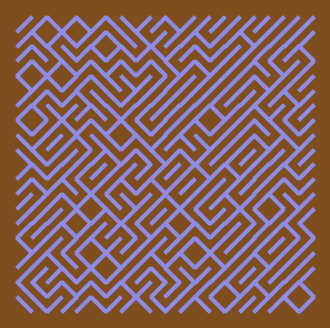

In [ ]:
dataset['train'][0]['image']

Now let's look at the label.

In [ ]:
dataset['train'][0]['text']

'a perrywinkle 10Print pattern on a milk chocolate background'